In [12]:
%matplotlib inline

# Packages
import os, glob, scipy, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# Project directory
base_dir = os.path.realpath('..')
print(base_dir)

# Project-specific functions
funDir = os.path.join(base_dir,'Code/Functions')
print(funDir)
sys.path.append(funDir)
import choiceModels, costFunctions, penalizedModelFit, simulateModel

# General-use python functions
dbPath = '/'.join(base_dir.split('/')[0:4])
sys.path.append('%s/Python'%dbPath)
import FigureTools

/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode
/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode/Code/Functions


## Choose study / condition

In [3]:
study = 1
model = 'MP_ppSOE'
baseMult = 4
precision = 100

# Load simulations

In [4]:
if baseMult == 4:
    cluster_threshold = 300
else:
    cluster_threshold = 700
if study == 2:
    cluster_threshold = 350

In [5]:
# Create theta-phi space
decimals = int(np.log10(precision)+1)
if model == 'MP_ppSOE':
    phi = np.around(np.arange(-0.1,0.10001,0.2/precision).astype('float'),decimals=decimals)#[-.1,0,.1]
    theta = np.around(np.arange(0,.50001,.5/precision).astype('float'),decimals=decimals)#[0,.1,.2,.3,.4,.5,.6]
    phiLen = len(phi)
    thetaLen = len(theta)
    phi[np.floor(len(phi)/2).astype(int)]=0
    thetaPhi = np.repeat(theta,phiLen)
    thetaPhi = pd.DataFrame(thetaPhi)
    thetaPhi.columns = ['theta']
    thetaPhi['phi'] = np.tile(phi,thetaLen)
    print (len(thetaPhi))
    print (thetaPhi.head())

10201
   theta    phi
0    0.0 -0.100
1    0.0 -0.098
2    0.0 -0.096
3    0.0 -0.094
4    0.0 -0.092


In [7]:
if study == 1:
    simulations = pd.read_csv(base_dir +
            '/Data/Study1/ComputationalModel/Simulations-short_study-%i_baseMult-%i_model-%s_precision-%i.csv'%(
                study,baseMult,model,precision),index_col=0)
elif study == 2:
    simulations = pd.read_csv(base_dir +
            '/Data/Study2/ComputationalModel/Simulations-short_study-%i_model-%s_precision-%i.csv'%(
                study,model,precision),index_col=0)
print (simulations.shape)
simulations.head()

(10201, 30)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,...,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0
1,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,...,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0
2,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,...,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0
3,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,...,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0
4,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,...,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0


## Create distance matrix

#### Settings

In [8]:
metric = 'sqeuclidean'

In [13]:
sim_distance = pdist(np.array(simulations),metric)

#### Cluster

In [14]:
Z = linkage(sim_distance,method='average')

In [15]:
# Dendrogram
if precision < 20:
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        color_threshold=cluster_threshold,
    )
    plt.show()

In [17]:
clusters = fcluster(Z, cluster_threshold, criterion='distance')
print (np.unique(clusters))

[1 2 3 4 5]


In [19]:
merge = None
if study == 2:
    merge = [1,5]
elif study == 1:
    if baseMult == 4:
        merge = [3,4]
print (merge)
if merge is not None:
    clusters[clusters==merge[0]] = merge[1]
mapping = dict(zip(np.unique(clusters),range(4)))
for clust in np.unique(clusters):
    clusters[clusters==clust] = mapping[clust]
print (np.unique(clusters))

[3, 4]
[0 1 2 3]


In [25]:
thetaPhi['cluster'] = clusters
fnstring = 'Study-%i'%study
if study == 1:
    fnstring = fnstring + '_baseMult-%i'%baseMult
thetaPhi.to_csv(base_dir + '/Data/Study%i/ComputationalModel'%study +
            '/ClusteringMapMelted_%s_model-%s_precision-100.csv'%(fnstring,model))
thetaPhiPivot = thetaPhi.pivot('theta','phi','cluster').T

#### Plot clusters in parameter space

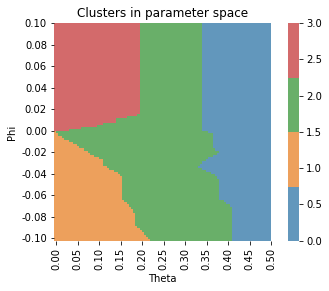

In [22]:
ncols = len(np.unique(clusters))
sns.set_palette('tab10',ncols,desat=.8)
weight_colorsByWhites = [3,1]
colorMap = sns.color_palette()[0:ncols]
colorMap = list(np.add(np.multiply(colorMap,weight_colorsByWhites[0]),
                       np.multiply(np.ones([ncols,3]),weight_colorsByWhites[1]))
                /sum(weight_colorsByWhites))
ax = sns.heatmap(thetaPhiPivot,cmap=colorMap,square=True)
plt.xlabel('Theta')
plt.ylabel('Phi')
plt.yticks(np.arange(1,phiLen+1,(phiLen-1)/10),['%.2f'%i for i in np.arange(-.1,.1001,2/(phiLen-1))])
plt.xticks(np.arange(1,thetaLen+1,(thetaLen-1)/10),['%.2f'%i for i in np.arange(0,.5001,5/(phiLen-1))])
plt.title('Clusters in parameter space')
ax.invert_yaxis()
plt.show()